In [2]:
import sys
sys.path.append('../')

import numpy as np
from itertools import product, permutations
from tqdm.notebook import tqdm
from multiprocessing import Pool
from GroupingAlgorithm import grouping, TPBgrouping
import matplotlib.pyplot as plt
import warnings
from utils import sort_solution, unpack_functions
warnings.simplefilter(action='ignore', category=FutureWarning)

# Dependence on how the input is sorted

We know that the grouping algorithm will have some dependence on how the Pauli strings are sorted and also how the measurements are assigned. This notebook is precisely to study that.

In [21]:
def n_groups(seed, random_order=True, basis=[4, 6, 7, 8, 9, 5, 3, 2, 1]):
    """Function that suffles the Pauli strings and feeds them to grouping"""
    
    if random_order:
        np.random.seed(seed)
        np.random.shuffle(order)
        Groups, _ = grouping(PS[order], basis, WC)
        return len(Groups), order
    else:
        Groups, _ = grouping(PS, basis, WC)
        return len(Groups) 
    
def n_groups_TPB(seed, random_order=True):
    """Function that suffles the Pauli strings and feeds them to TPBgrouping"""

    if random_order:
        np.random.seed(seed)
        np.random.shuffle(order)
        Color, Groups, Measurements = TPBgrouping(PS[order])
        return len(Groups), order
    else:
        Color, Groups, Measurements = TPBgrouping(PS)
        return len(Groups) 

## Order Paulis Only TPB

We first check if the order in which Pauli strings are introduced affects the grouping when only TPB bases are considered. 

For that we construct all the $4^4 = 256$ 4-qubit Pauli strings and try for 5000 different sortings. Notice that it is not possible to go through all $256!$ different sortings.

In [22]:
num_qubits = 4
num_strings = 256
PS = np.array(list(product([0, 1, 2, 3], repeat=num_qubits)))
order = np.arange(num_strings)  #Parameter for the random sorting function

Code for a parallel computation of the 5000 different sortings.

In [23]:
n = 5000
args = []
results = []

for i in range(n):
    args.append([i, n_groups_TPB, [i]])  #call the TPBgrouping function
    
pbar = tqdm(total=n)
pool = Pool()
for i, result in enumerate(pool.imap_unordered(unpack_functions, args, chunksize=1), 1): 
        results.append(result) # Save the result
        pbar.update() #Update the progress bar
        
pool.terminate()
pbar.close()
results = sort_solution(results) # Sort the asyn results

number_grups = []
orders = []
for result in results:
    number_grups.append(result[0])
    orders.append(result[1])
    
results = None

print('Minimum number of groups:', min(number_grups))
print('Maximum number of groups:', max(number_grups))


Minimum number of groups: 81
Maximum number of groups: 81


As it was suspected, since all the TPB are measured locally, there should be no difference in grouping as we introduce the Pauli strings in different orders.

## Order Paulis with entangled measurements

In [31]:
num_qubits = 4
num_strings = 256
WC = list(range(num_qubits))
WC = list(permutations(list(range(num_qubits)), 2))

PS = np.array(list(product([0, 1, 2, 3], repeat=num_qubits)))
order = np.arange(num_strings)

In [32]:
n = 10000
args = []
results = []

for i in range(n):
    args.append([i, n_groups, [i]])  #call the TPBgrouping function
    
pbar = tqdm(total=n)
pool = Pool()
for i, result in enumerate(pool.imap_unordered(unpack_functions, args, chunksize=1), 1): 
        results.append(result) # Save the result
        pbar.update() #Update the progress bar
        
pool.terminate()
pbar.close()
results = sort_solution(results) # Sort the asyn results

number_grups = []
orders = []
for result in results:
    number_grups.append(result[0])
    orders.append(result[1])
    
results = None

print('Minimum number of groups:', min(number_grups))
print('Maximum number of groups:', max(number_grups))


Minimum number of groups: 37
Maximum number of groups: 49


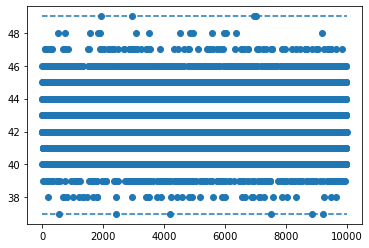

In [34]:
plt.plot(number_grups, 'o')
plt.hlines(min(number_grups), 0, n, ls='--')
plt.hlines(max(number_grups), 0, n, ls='--')
plt.show()

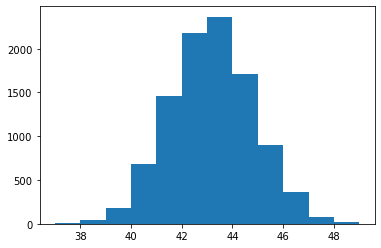

In [35]:
num_bins = max(number_grups) - min(number_grups)
plt.hist(number_grups, num_bins);
plt.show()

As we suspected from the struture of our algorithm, the grouping depends on the way the Pauli strings are introduced. We observe however, that the groups concentrate nicely around the mean value, which menas that if we introduce a random sorting it will likely fall close to that value. 

__Notice that even the worst value of the grouping (49 groups) is still much better than the TPB value of 81 groups.__

## Dependence on the order of bases

There are 9 different bases in which we can measure. This means that there $9! = 362880$ ways in which the order of measurements can be assigned. Here we run a simulation over all these posibilities which takes around 5 hours to execute.

In [8]:
order = orders[np.argmin(number_grups)]
PS = np.array(list(product([0, 1, 2, 3], repeat=num_qubits)))[order] # take the sorting of PS that resulted 
                                                                     # in a better grouping
                                                                     
groups_basis = list(permutations([1, 2, 3, 4, 5, 6, 7, 8, 9], 9)) # Try the 9! order of measurements over that
n = len(groups_basis)                                             # best grouping.
args = []
results = []

for i in range(n):
    args.append([i, n_groups, [i], {'basis': groups_basis[i], 'random_order': False}])
    
pbar = tqdm(total=n)
pool = Pool()
for i, result in enumerate(pool.imap_unordered(unpack_functions, args, chunksize=1), 1): 
        results.append(result) # Save the result
        pbar.update() #Update the progress bar
        
pool.terminate()
pbar.close()
results = np.array(sort_solution(results)) # Sort the asyn results

print('Minimum number of groups:', min(results))
print('Maximum number of groups:', max(results))


Minimum number of groups: 38
Maximum number of groups: 44


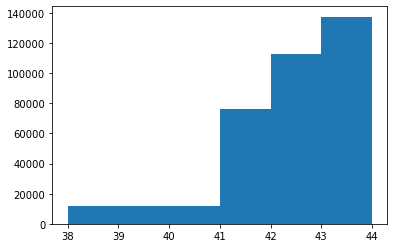

In [11]:
num_bins = max(results) - min(results)
plt.hist(results, num_bins);

In [20]:
index_min = np.argmin(results)
print('The best basis orders are:')
best_basis = []
for i in range(n):
    if results[i] == results[index_min]:
        best_basis.append(groups_basis[i])
        print(groups_basis[i])

The best basis orders are:
(1, 2, 3, 4, 6, 5, 7, 8, 9)
(1, 2, 3, 4, 6, 5, 7, 9, 8)
(1, 2, 3, 4, 6, 5, 8, 7, 9)
(1, 2, 3, 4, 6, 5, 8, 9, 7)
(1, 2, 3, 4, 6, 5, 9, 7, 8)
(1, 2, 3, 4, 6, 5, 9, 8, 7)
(1, 2, 3, 4, 6, 7, 5, 8, 9)
(1, 2, 3, 4, 6, 7, 5, 9, 8)
(1, 2, 3, 4, 6, 7, 8, 5, 9)
(1, 2, 3, 4, 6, 7, 8, 9, 5)
(1, 2, 3, 4, 6, 7, 9, 5, 8)
(1, 2, 3, 4, 6, 7, 9, 8, 5)
(1, 2, 3, 4, 6, 8, 5, 7, 9)
(1, 2, 3, 4, 6, 8, 5, 9, 7)
(1, 2, 3, 4, 6, 8, 7, 5, 9)
(1, 2, 3, 4, 6, 8, 7, 9, 5)
(1, 2, 3, 4, 6, 8, 9, 5, 7)
(1, 2, 3, 4, 6, 8, 9, 7, 5)
(1, 2, 3, 4, 6, 9, 5, 7, 8)
(1, 2, 3, 4, 6, 9, 5, 8, 7)
(1, 2, 3, 4, 6, 9, 7, 5, 8)
(1, 2, 3, 4, 6, 9, 7, 8, 5)
(1, 2, 3, 4, 6, 9, 8, 5, 7)
(1, 2, 3, 4, 6, 9, 8, 7, 5)
(1, 2, 4, 3, 6, 5, 7, 8, 9)
(1, 2, 4, 3, 6, 5, 7, 9, 8)
(1, 2, 4, 3, 6, 5, 8, 7, 9)
(1, 2, 4, 3, 6, 5, 8, 9, 7)
(1, 2, 4, 3, 6, 5, 9, 7, 8)
(1, 2, 4, 3, 6, 5, 9, 8, 7)
(1, 2, 4, 3, 6, 7, 5, 8, 9)
(1, 2, 4, 3, 6, 7, 5, 9, 8)
(1, 2, 4, 3, 6, 7, 8, 5, 9)
(1, 2, 4, 3, 6, 7, 8, 9, 5)
(1, 2, 4, 3, 6, 7, 9,

In [22]:
len(best_basis)

12096

This simulation was run for the best grouping obtained for a given basis order, which in this case was 38 groups. The inspection found $12096$ order of bases that behave equally well, but __None better__.

Guided by this intuition what we did was to establish a measurement order in which the measurement circuits with lowest error were given priority, ans then, over this pre-established order we tried several Pauli string sortings.

In [1]:
import qiskit.tools.jupyter
%qiskit_version_table